## Amdahl's and Strong Scaling  

Amdahl's law is the fundamental principle behind _strong scaling_ in parallel computing.  
Strong scaling is the process of solving a problem of the _fixed size_ faster with parallel resources.  The improvement in performance is measured as _speedup_.  

  * $T(1)$ = time to execute task on a single resource
  * $T(n)$ = time to execute task on n resources
  * Speedup = $T(1)/T(n)$

Examples include:

  * parallel data analysis for high-frequency trading
  * key cracking in cryptosystems
  * training a deep-neural network on a corpus of examples
  
In all, the data remains the same size and the goal is to complete the computation faster.
 
_Activity_: write down an example problem that would benefit from speedup.

### Concepts in this unit
  * Amdahl's law
  * strong scaling
  * speedup
  * speedup estimation
  * parallel efficiency
  
### Outcomes
The ability to apply Amdahl's in both directions:
  * to estimate scalability parameters based on a black box implementation of a parallel program
  * to estimate how a given problem will scale based on an instrumentation of a serial program

## Amdahl's Law 

Improving a portion $p$ of a computation by factor $s$ results in an overall speedup of

$$S_{\mbox{latency}}(s) = \frac{1}{1-p+\frac{p}{s}}$$

* _p_ is the proportion of execution time that benefits from improved resources, i.e. the parallel part
* _(1-p)_ is the portion that does not benefit; i.e. the serial part
* _s_ is the speedup of the optimized part
* _S<sub>latency</sub>(s)_ theoretical speedup of the whole task

Paraphrased: speedup limited to fraction improved

<img src="images/al2.png" width="512" title="Amdahl's Law Graph (from Greg Ganger)" />

### Visualizing Amdahl's Law

Let's look at the Amdahl curve for a given parallel fraction (.95).


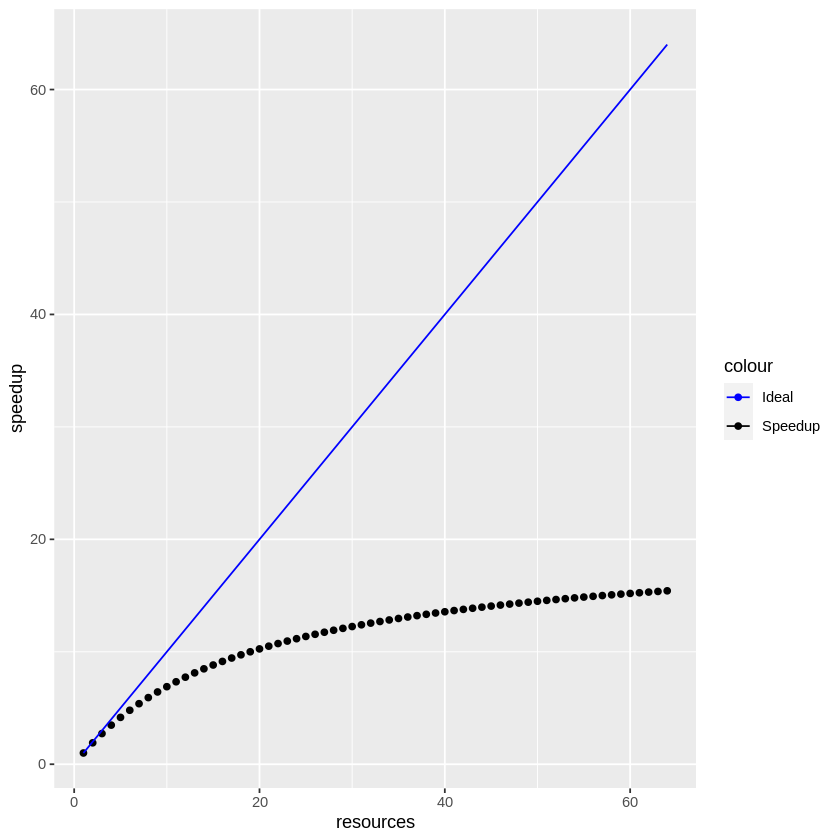

In [2]:
library(ggplot2)
library(repr)
#options(repr.plot.width=4, repr.plot.height=3)

# Let's assume we have a 4 socket x 16 core machine. Up to 64 resources.
resources = seq(1:1:64)
p = .95
        
amdahl <- data.frame(resources, 1/((1-p)+p/resources))
colnames(amdahl) <- c("resources","speedup")

aplot <- ggplot(amdahl, aes(x=resources, y=speedup, color="Speedup")) + geom_point() +
            geom_line(data=amdahl, aes(x=resources,y=resources, color="Ideal")) +
            scale_color_manual(values = c("Speedup" = 'black','Ideal' = 'blue'))

print(aplot)

#### Properties of a Speedup Plot

* x-axis should have resources
* y-axis should be speedup ($T(1)/T(n)$)
* axes should be linear-linear or log-log (log-log more common)

#### Linear (Ideal) Speedup

According to Amdahl's law, the best speedup is achieved when $p=1$ and $S=s$.
  * entire computation optimized
  * doubling resources doubles speed
 
This is the efficiency limit and is often plotted in speedup charts to see the loss of parallelism.

### Scaling

Let's now look at how performance scales as function of the parallel fraction.

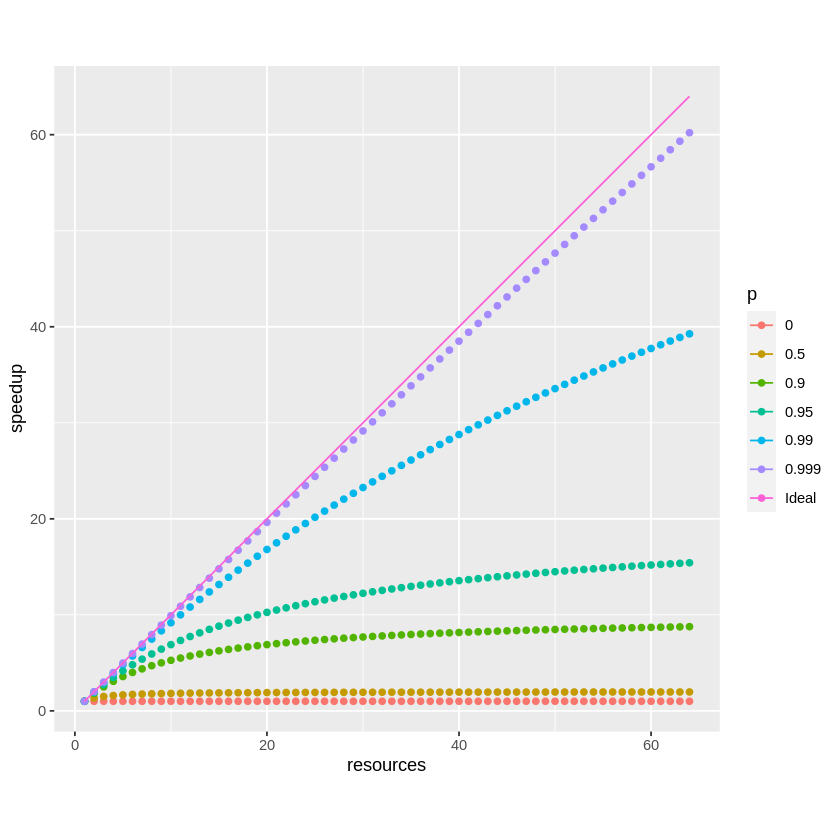

In [3]:
library(tidyr)

resources = seq(1:1:64)

# examine a range of parallel fractions
p = factor(c(0,.5,.9,.95,.99,.999))

# build a data frame 
df <- data.frame(crossing(resources,p))
df$pnumeric <- as.numeric(levels(df$p))[df$p]

# with speedup
df$speedup <- 1/((1-df$pnumeric)+df$pnumeric/df$resources)

plt <- ggplot(df, aes(x=resources, y=speedup))+geom_point(aes(color=p)) +
            geom_line(data=df, aes(x=resources,y=resources, color="Ideal")) +
            coord_fixed()
print(plt)

### Amdahl's law defeats parallel performance

The graph indicates that even a small amount of inefficiency reduces scaleup at a modest amount of parallelism.
Let's look at this the other way around.

* Suppose you want to achieve a speedup of 80 with 100 processors, what fraction of the original computation can be sequential?

In [4]:
# 80 = 1 / ((1-p)+p/100)
p = (100-100/80)/99
p

[1] 0.9974747

So, about $1/4$ of one percent. Not much!  This is the downfall of parallelism.

#### So what is serial?

We say 'serial' as a simple abstraction for the unoptimized portion.  Its an abstraction to reason about parallelism.
* Sometimes literal:
  * Code running in a single thread before the parallel part starts
  * File I/O before launching a program
* Sometimes metaphorical:
  * When one/few processes are running while others are idle 
  * When parallelism introduces additional computation

The unoptimized fraction of the code occurs
when not all resources are doing useful work at full capacity.

### Inferring parallelism from Amdahl's Law

Simplifying unoptimized into serial and parallel allows us to infer an __Amdahl Number__ from 
the empirical performance of a code.

In [5]:
# we measure perforamnce as a function of processors. 
processors = c(2,4,8,16,32)
speedup = c(1.85, 3.30, 5.34, 7.4, 9.4)
amdahl_number <- processors/(processors-1)*(1-1/speedup)
amdahl_number

[1] 0.9189189 0.9292929 0.9288390 0.9225225 0.9224434

In [6]:
8/(8-1)*(1-1/4)

[1] 0.8571429

So, we would say that this code seems to have an Amdahl # of about .92.  The can be converted into a maximum possible speedup.

* Amdahl's law implies that the unoptimized fraction of the code dictates exactly how much speedup can be obtained on __an infinite number of cores__.

$$S_{\mbox{latency}}(s) = \frac{1}{1-p+\frac{p}{\infty}} = \frac{1}{1-p}$$

In [7]:
slim <- 1/(1-0.94)
slim

[1] 16.66667

Warning message:
“Removed 108 row(s) containing missing values (geom_path).”


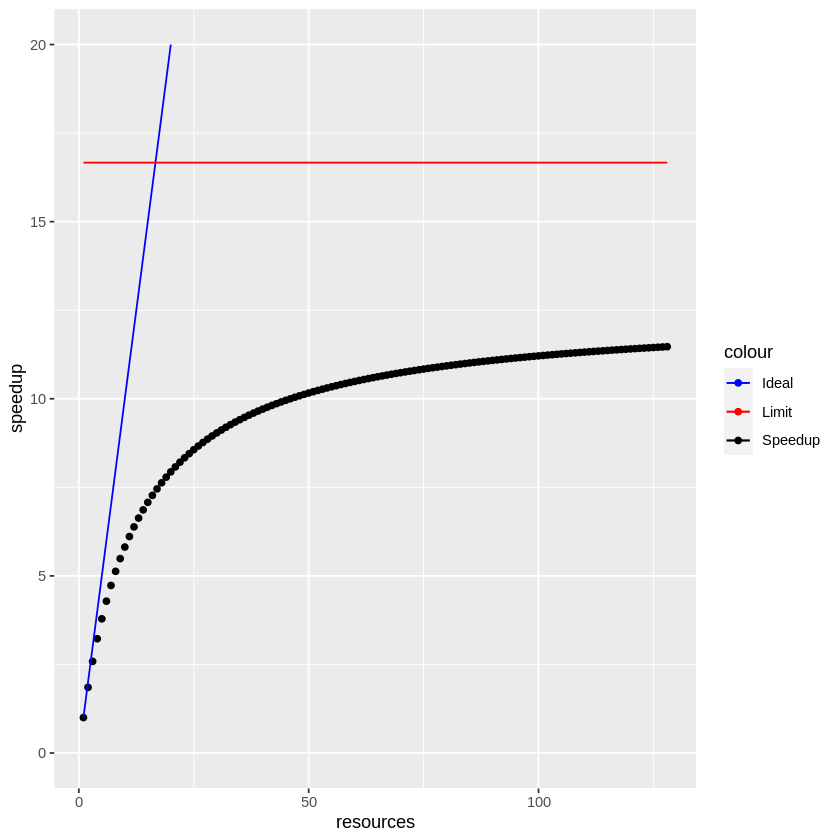

In [8]:
resources = seq(1:1:128)
p = .92
        
amdahl <- data.frame(resources, slim, 1/((1-p)+p/resources))
colnames(amdahl) <- c("resources", "limit", "speedup")

aplot <- ggplot(amdahl, aes(x=resources, y=speedup, color="Speedup")) + geom_point() +
            geom_line(data=amdahl, aes(x=resources,y=resources, color="Ideal")) +
            geom_line(data=amdahl, aes(x=resources,y=limit, color="Limit")) +
            scale_color_manual(values = c("Speedup" = 'black','Ideal' = 'blue', 'Limit'='red')) + ylim(0,20)
print(aplot)

_Activity_: Given the fraction of serial computation that is optimized and unoptimized for the following code snippet
<code>
    
    // 2% of serial execution spent outside of the loop
    ...some computation here...

    // 98% of serial execution spent in this loop that is parallelized
    #pragma omp parallel for 
    for (int i=0; i<N; i++ )
    { 
        ...other computation here...
    }
</code> 

__draw a speedup chart__ that includes
  - 3 points on the Amdahl's law curve (give exact values),
  - include the line of ideal parallelism that serves as an upper
    bound for all speedup, and 
  - include the asymptote for the maximum possible speedup
    for this code.

## Parallel Efficiency

Companion concept to speedup.
* Efficiency; $E = S(n)/n = T(1)/nT(n)$
* Informally: fraction of possible performance realized

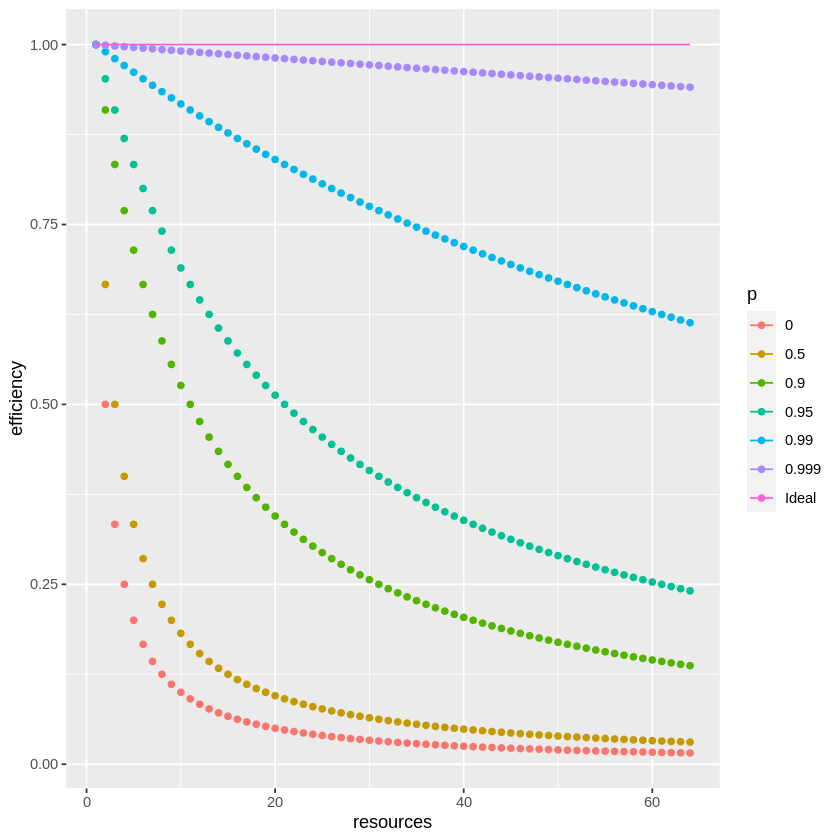

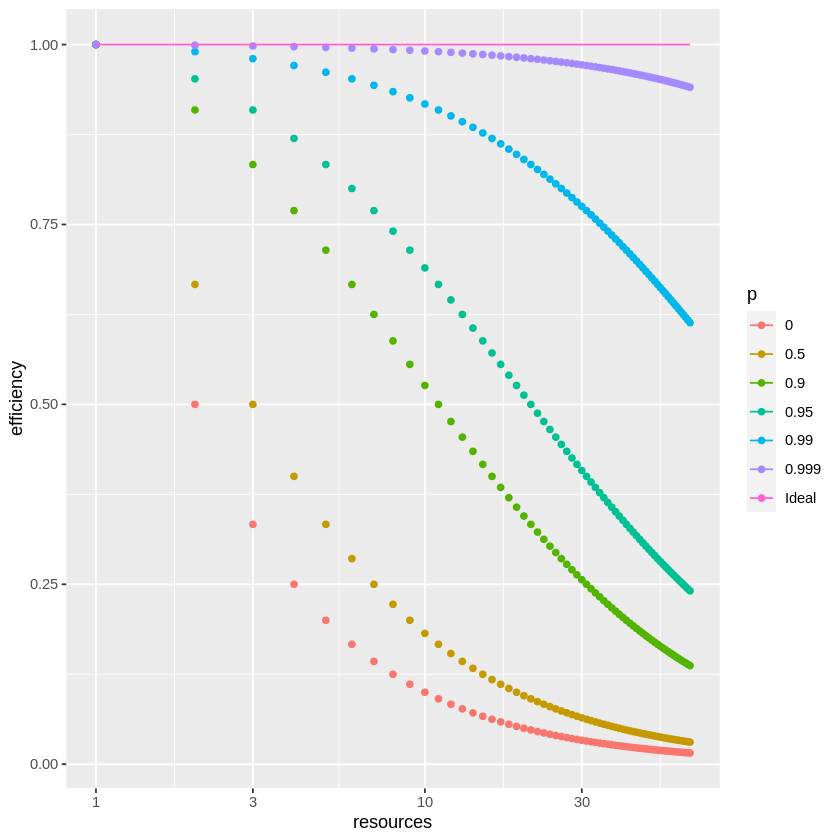

In [9]:
resources = seq(1:1:64)

# and a sequence of parallel fractions
p = factor(c(0,.5,.9,.95,.99,.999))

# build a data frame 
df <- data.frame(crossing(resources,p))
df$pnumeric <- as.numeric(levels(df$p))[df$p]

# with speedup
df$speedup <- 1/((1-df$pnumeric)+df$pnumeric/df$resources)

# and efficiency
df$efficiency <- df$speedup/df$resources

# plot in linear/linear space
plt <- ggplot(df, aes(x=resources, y=efficiency))+geom_point(aes(color=p)) +
            geom_line(data=df, aes(x=resources,y=1, color="Ideal"))
print(plt)

#plot in log/linear space
plt <- ggplot(df, aes(x=resources, y=efficiency))+geom_point(aes(color=p)) +
            geom_line(data=df, aes(x=resources,y=1, color="Ideal")) +
            scale_x_log10()
print(plt)

No common convention about plotting efficiency
* Typically to have efficiency be linear scale and x-axis be either log of linear.
* linear/linear has better intuition
* log/linear is not monotonic
The shapes of efficiency plots are characteristic. Be careful to read axes.

## Parting Thoughts

Performance in practice is much more complex than splitting a code into a "unoptimized" and "optimized" portion.  But we will see that Amdahl's law is incredibly useful in:
  * Back of the envelope calculations about scalability limits (setting a speed limit)
  * Deciding what portions of a complex software application is worth optimizing
  
A typical optimization process for a piece of software
  * implement a serial solution
  * instrument/profile code to determine how much time is spent in what steps
  * optimize only the expensive steps 
    * it's hard work writing parallel programs (10x harder than serial)
    * or choose not to parallelize, because the speedup limit is not good enough
    
So we use Amdahl's law to:
  * choose whether to parallelize a solution
  * pick what part of our program to optimize